In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import CrossEncoder, util, SentenceTransformer

/home/julrich/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-30 15:00:47.658054: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
embeddings_location = 'page-embeddings-selected.pkl'

print("Loading pre-computed embeddings from disc: " + embeddings_location)
with open(embeddings_location, "rb") as reader:
    cache_data = pickle.load(reader)
    sections = cache_data['sections']
    corpus_embeddings = cache_data['embeddings']

print('Corpus embeddings loaded.')
print('Corpus embedding size:', corpus_embeddings.shape)

Loading pre-computed embeddings from disc: page-embeddings-selected.pkl
Corpus embeddings loaded.
Corpus embedding size: (5978, 384)


In [3]:
df_sections = pd.DataFrame.from_records(pd.json_normalize(sections, sep='_'))
df_sections['newlines'] = df_sections['content'].str.count('\n')
df_sections['whitespace'] = df_sections['content'].str.count(' ')
df_sections['special_chars'] = df_sections['content'].replace('\n', ' ').str.count('[^a-zA-Z0-9 ]')

In [4]:
df_long_sections = df_sections[
    (df_sections['tokens'].isna() |
    df_sections['tokens'].gt(250)) &
    df_sections['newlines'].gt(3) &
    df_sections['newlines'].lt(16) &
    df_sections['whitespace'].gt(120)
].drop_duplicates(subset=['content'])

df_long_section_ids = df_long_sections.index

numpy_sections = np.array(sections)
numpy_embeddings = np.array(corpus_embeddings)

selected_sections = numpy_sections[df_long_section_ids]
selected_embeddingns = numpy_embeddings[df_long_section_ids]


In [24]:
with open('page-embeddings-selected.pkl', "wb") as writer:
    pickle.dump({'sections': selected_sections, 'embeddings': selected_embeddingns}, writer)

In [6]:
df_long_sections
print(len(df_long_sections))
pd.set_option('display.max_colwidth', None)
df_long_sections[['content', 'whitespace', 'newlines', 'special_chars']].sample(10)

5978


,content,whitespace,newlines,special_chars
4028,"React Core\nThe React Core team members work full time on the core component APIs, the engine that powers React DOM and React Native, React DevTools, and the React documentation website.\nCurrent members of the React team are listed in alphabetical order below.\nAndrew Clark\nEngineer at VercelAndrew got started with web development by making sites with WordPress, and eventually tricked himself into doing JavaScript. His favorite pastime is karaoke. Andrew is either a Disney villain or a Disney princess, depending on the day.\nacdlite acdlite\nAndrey Lunyov\nEngineer at MetaAndrey started his career as a designer and then gradually transitioned into web development. After joining the React Data team at Meta he worked on adding an incremental JavaScript compiler to Relay, and then later on, worked on removing the same compiler from Relay. Outside of work, Andrey likes to play music and engage in various sports.\nalunyov alunyov",140,8,24
4478,"Now, the setInterval callback executes once a second, but each time the inner call to setCount can use an up-to-date value for count (called c in the callback here.)\nIn more complex cases (such as if one state depends on another state), try moving the state update logic outside the effect with the useReducer Hook. This article offers an example of how you can do this. The identity of the dispatch function from useReducer is always stable — even if the reducer function is declared inside the component and reads its props.\nAs a last resort, if you want something like this in a class, you can use a ref to hold a mutable variable. Then you can write and read to it. For example:\nfunction Example(props) {\n // Keep latest props in a ref. const latestProps = useRef(props); useEffect(() => { latestProps.current = props; });\n useEffect(() => {\n function tick() {\n // Read latest props at any time console.log(latestProps.current); }",164,7,65
3339,"Generating our content\nIf we now want to deploy our amazing new blog we can run the nuxt generate command which will build our app adding all our webpack assets and creating .js bundles for us and then export our html, css, js and images as static assets. You will also notice that we didn't have to add a routes property or do anything to get our new page as the crawler will crawl all links for us and generate our dynamic routes for us.\nWe can then use the nuxt start command which will serve our production ready static site so we can see it in our browser before deploying.\nWith nuxt generate if only our content changes it means the nuxt generate command will only export the static pages and will not go through webpack to rebuild the site meaning our content will be updated in seconds.\nConclusion\nWorking with content is great fun and there is so much more you can do and build. Don't forget to showcase your work to use on our discord channel named showcase so we can see the cool things you have created and perhaps even feature them in our NuxtLetter. Not signed up yet? Well now is a great time to sign up as we keep releasing more new content and features for Nuxt. Enjoy :)",220,5,20
1395,"Jeremy Faludi\nAssistant Professor at Dartmouth College\n\nThe third one is biomimicry, which is the idea of looking to nature for inspiration, since nature already has a sustainable manufacturing and recycling system that’s been going on for 3.8 billion years.\n\nIt was really interesting to see what people valued and criticized about each of these things. A couple of the main takeaways were: \n\nMost companies have no idea of all the tools available out there. Aside from these three, there were 11 others I profiled in my research. Companies valued bits and pieces of each, but nobody really wants to just do one.\nDesign methods are not tunnels of process, where you jump in one side, do all the steps, and then get spat out the other side with a brilliant design. They’re more like toolboxes, where a given design met

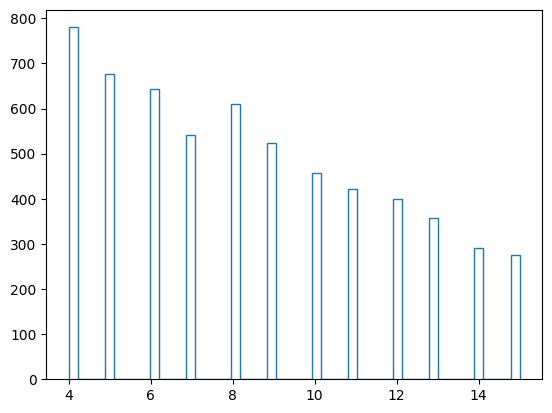

In [7]:
plt_range = [df_long_sections['newlines'].min(), df_long_sections['newlines'].max()]

counts, bins = np.histogram(df_long_sections['newlines'], range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)

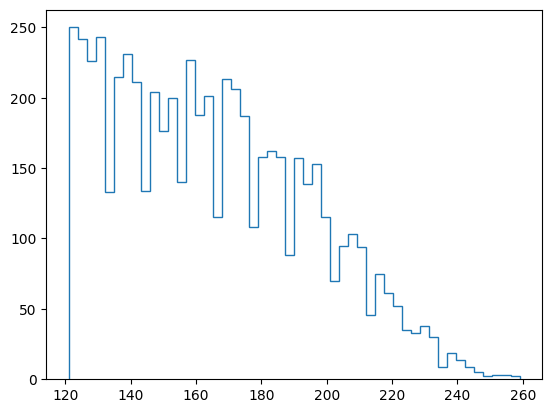

In [8]:
plt_range = [df_long_sections['whitespace'].min(), df_long_sections['whitespace'].max()]

counts, bins = np.histogram(df_long_sections['whitespace'], range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)

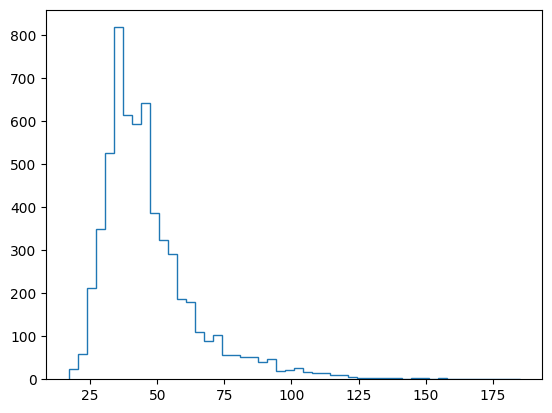

In [9]:
plt_range = [df_long_sections['special_chars'].min(), df_long_sections['special_chars'].max()]

counts, bins = np.histogram(df_long_sections['special_chars'], range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)

In [39]:
bi_encoder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
bi_encoder.max_seq_length = 256

top_k = 32
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def getSectionContent(section):
    return section['content'].replace('\n', ' ').strip()

passages = []
passages.extend(map(getSectionContent, sections))

def search(query):
    print("Input question:", query)

    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    # Change back to .cuda() when GPU is available on Codespace
    question_embedding = question_embedding.cpu()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]

    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    print("\n-------------------------\n")
    print("Top-5 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], passages[hit['corpus_id']].replace("\n", " ")))

In [40]:
search('What is a Design System?')

Input question: What is a Design System?

-------------------------

Top-5 Cross-Encoder Re-ranker hits
	10.865	What is a design system? A design system is the source of truth, governing principles, and componentized delivery of design artifacts that repeatedly solves commonly recurring problems across an organization. This might be a mouthful of a definition, but there’s a reason for that. If you go around asking people “what exactly is a design system?” you’ll get different answers from everyone. To prove a point, I asked around our own team of dedicated design system professionals, and here are a couple of their definitions: “Repeatable solutions for commonly recurring problems” “A collection of design artifacts, and connection between design and developers” “Componentized delivery of designs, not just a style guide” Even if you search on Google, you’ll find equally different answers. But the thing is, none of them are wrong, design systems are all of these definitions combined. The

In [41]:
search('Who is Brad Frost?')

Input question: Who is Brad Frost?

-------------------------

Top-5 Cross-Encoder Re-ranker hits
	7.309	Hey there!   I'm Brad Frost, a design system consultant, web designer, speaker, writer, and musician located in beautiful Pittsburgh, PA. *  * ### Atomic Design I wrote a book called Atomic Design, which covers all that goes into creating and maintaining effective design systems. You can read it online and  order the ebook. *  * [### Wanna work together? I'm a principal and technical strategist at Big Medium, where we help teams establish and evolve design systems, establish more collaborative workflows, and create better software together. Need design system help? Need help leveling up your organization's digital practice? Get in touch!](/work) * [### Blog I write about web design best practices, design systems, responsive design, and other tasty topics on my blog. I also enjoy sharing and commenting on interesting links from around the web.](/blog) * [### Contact
	5.425	I dunno | 

In [45]:
search('How can you ensure Accessibility?')

Input question: How can you ensure Accessibility?

-------------------------

Top-5 Cross-Encoder Re-ranker hits
	4.686	Accessibility Ensure that view more/less is operable by keyboard Users should be able to select the component by pressing tab and enter to expand or contract. The space bar can also be used to toggle the more/less link between open and closed. WCAG 2.1: 2.1.3 Keyboard (No Exception) View more/less labels should be clear, concise, and accurately descriptive Any content which has been hidden within a view more/less should be obvious from the label alone, such as “Warranty details.” WCAG 2.1: 1.3.1 Info and Relationships Any lists with items hidden with view more/less should make the total items obvious from the outset Hiding list items is discouraged in general, as it can be misleading. If you need to hide list items, make sure the total number of items is stated clearly up front (either with a heading, or in the immediately preceding text) so people understand that the